# Análise do Experimento de Difração de Elétrons

**Universidade Federal da Bahia - Instituto de Física**

**Laboratório de Estrutura da Matéria**

---

## Objetivo

Este notebook implementa a análise de dados do experimento de difração de elétrons, seguindo o roteiro experimental. Os objetivos principais são:

1. Calcular os raios médios dos anéis de difração e suas incertezas
2. Determinar os comprimentos de onda experimentais dos elétrons
3. Comparar com as previsões da teoria de De Broglie
4. Determinar experimentalmente a constante de Planck através de análise gráfica
5. Avaliar a compatibilidade do resultado com o valor teórico aceito

## 1. Importação de Bibliotecas e Definição de Constantes

Primeiro, importamos as bibliotecas necessárias e definimos as constantes físicas que utilizaremos.

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuração para melhorar a aparência dos gráficos
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


In [84]:
# Constantes físicas fundamentais
h_teorico = 6.626e-34  # J·s - Constante de Planck (valor teórico aceito)
m_e = 9.109e-31        # kg - Massa do elétron
e = 1.602e-19          # C  - Carga elementar

# Parâmetros do experimento
d10 = 0.213  # nm - Espaçamento interplanar do grafite (anel interno)
d11 = 0.123  # nm - Espaçamento interplanar do grafite (anel externo)
L = 125      # mm - Distância entre a grade de grafite e a tela fluorescente
s_L = 2      # mm - Incerteza na distância L

print("="*70)
print("CONSTANTES FÍSICAS UTILIZADAS")
print("="*70)
print(f"Constante de Planck (h):           {h_teorico:.3e} J·s")
print(f"Massa do elétron (m_e):            {m_e:.3e} kg")
print(f"Carga elementar (e):               {e:.3e} C")
print(f"Espaçamento grafite d₁₀ (interno): {d10} nm")
print(f"Espaçamento grafite d₁₁ (externo): {d11} nm")
print(f"Distância grade-tela (L):          {L} ± {s_L} mm")
print("="*70)

CONSTANTES FÍSICAS UTILIZADAS
Constante de Planck (h):           6.626e-34 J·s
Massa do elétron (m_e):            9.109e-31 kg
Carga elementar (e):               1.602e-19 C
Espaçamento grafite d₁₀ (interno): 0.213 nm
Espaçamento grafite d₁₁ (externo): 0.123 nm
Distância grade-tela (L):          125 ± 2 mm


## 2. Carregamento e Preparação dos Dados

Carregamos os dados experimentais do arquivo CSV. Os dados contêm medições dos diâmetros dos anéis de difração (interno e externo) para diferentes tensões de aceleração.

In [85]:
# Lendo os dados do CSV
df = pd.read_csv('Difração de eletróns - Página1.csv',
                 skiprows=1,  # Pula a primeira linha vazia
                 decimal=',')  # Vírgula como separador decimal

# Renomeando colunas para facilitar o uso
df.columns = ['Tensao_kV', 'D1_int', 'D1_ext', 'D2_int', 'D2_ext', 'pessoa']

# Convertendo tensão de kV para V
df['Tensao_V'] = df['Tensao_kV'] * 1000

# Convertendo diâmetros para numérico (caso haja problemas de formatação)
for col in ['D1_int', 'D1_ext', 'D2_int', 'D2_ext']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculando raios a partir dos diâmetros (r = D/2)
df['r1_int'] = df['D1_int'] / 2  # Raio interno do anel 1
df['r1_ext'] = df['D1_ext'] / 2  # Raio externo do anel 1
df['r2_int'] = df['D2_int'] / 2  # Raio interno do anel 2
df['r2_ext'] = df['D2_ext'] / 2  # Raio externo do anel 2

print("✓ Dados carregados com sucesso!\n")
print(f"Total de medições: {len(df)}")
print(f"Tensões diferentes: {df['Tensao_V'].nunique()}")
print(f"Faixa de tensão: {df['Tensao_V'].min():.0f} V a {df['Tensao_V'].max():.0f} V")
print("\nPrimeiras linhas dos dados:")
df[['Tensao_V', 'r1_int', 'r1_ext', 'r2_int', 'r2_ext', 'pessoa']].head(10)

✓ Dados carregados com sucesso!

Total de medições: 43
Tensões diferentes: 11
Faixa de tensão: 3000 V a 5000 V

Primeiras linhas dos dados:


,Tensao_V,r1_int,r1_ext,r2_int,r2_ext,pessoa
0,3000.0,12.825,14.000,19.400,23.300,f
1,3000.0,9.325,11.625,16.800,20.625,m
2,3000.0,11.750,14.500,19.900,23.500,g
3,3200.0,9.075,11.325,17.600,22.000,m
4,3200.0,11.600,12.750,17.950,21.000,p
5,3200.0,10.650,12.750,16.800,21.300,f
6,3200.0,11.550,11.225,20.675,23.175,g
7,3400.0,10.850,12.075,17.500,19.150,f
8,3400.0,10.500,14.150,17.175,22.750,m
9,3400.0,10.100,14.400,13.100,21.300,p


## 3. Seção 5.1 - Cálculo dos Raios Médios e Incertezas

**Entendimento dos dados:**
- Para cada tensão, temos 4 medições de 4 pessoas diferentes
- Cada medição contém:
  - **Anel interno (D1)**: diâmetro da borda interna (D1_int) e borda externa (D1_ext)
  - **Anel externo (D2)**: diâmetro da borda interna (D2_int) e borda externa (D2_ext)

**Procedimento de cálculo:**

1. **Raio efetivo de cada anel** em cada medição: média entre borda interna e externa
   $$r^{(i)}_1 = \frac{r^{(i)}_{1,int} + r^{(i)}_{1,ext}}{2}$$
   $$r^{(i)}_2 = \frac{r^{(i)}_{2,int} + r^{(i)}_{2,ext}}{2}$$

2. **Centro verdadeiro dos anéis**: média entre os dois raios médios (ponto central entre os dois anéis)
   $$r_{centro} = \frac{\bar{r}_1 + \bar{r}_2}{2}$$

3. **Raios desde o centro**: cada raio é a distância desde o centro verdadeiro até o anel
   - Anel interno: $r_1 = r_1 - r_{centro}$ (pode ser negativo se estiver do lado de dentro)
   - Anel externo: $r_2 = r_2 - r_{centro}$ (deve ser positivo)
   
   Mas como queremos as **distâncias absolutas**, usamos:
   $$R_1 = |r_1 - r_{centro}|$$
   $$R_2 = |r_2 - r_{centro}|$$

4. **Raio médio** para cada tensão: média das 4 medições
   $$\bar{r}_1 = \frac{1}{n}\sum_{i=1}^{n} r^{(i)}_1$$

5. **Incerteza estatística**: desvio padrão da média
   $$s_{\bar{r}_1} = \frac{1}{\sqrt{n}}\sqrt{\frac{\sum_{i=1}^{n}(r^{(i)}_1 - \bar{r}_1)^2}{n-1}}$$

In [86]:
print("="*70)
print("SEÇÃO 5.1 - CÁLCULO DOS RAIOS MÉDIOS E INCERTEZAS")
print("="*70)

# Calculando raio efetivo para cada medição (média entre borda interna e externa)
df['r1'] = (df['r1_int'] + df['r1_ext']) / 2  # Raio do anel interno
df['r2'] = (df['r2_int'] + df['r2_ext']) / 2  # Raio do anel externo

# Salvando dados individuais para referência (sem análise detalhada)
resultados_por_pessoa = []
for tensao in sorted(df['Tensao_V'].unique()):
    dados_tensao = df[df['Tensao_V'] == tensao]
    for pessoa in dados_tensao['pessoa'].unique():
        dados_pessoa = dados_tensao[dados_tensao['pessoa'] == pessoa]
        resultados_por_pessoa.append({
            'Tensao_V': tensao,
            'pessoa': pessoa,
            'r1': dados_pessoa['r1'].values[0],
            'r2': dados_pessoa['r2'].values[0]
        })

df_individual = pd.DataFrame(resultados_por_pessoa)

# Agrupando por tensão e calculando estatísticas gerais
resultados = []

for tensao in sorted(df['Tensao_V'].unique()):
    dados_tensao = df[df['Tensao_V'] == tensao]
    
    # Número de medições (4 pessoas)
    n = len(dados_tensao)
    
    # Raios médios
    r1_medio = dados_tensao['r1'].mean()
    r2_medio = dados_tensao['r2'].mean()
    
    # O centro geométrico é a média entre os dois anéis
    r_centro = (r1_medio + r2_medio) / 2
    
    # Desvio padrão da média (incerteza estatística)
    s_r1 = dados_tensao['r1'].std(ddof=1) / np.sqrt(n) if n > 1 else 0
    s_r2 = dados_tensao['r2'].std(ddof=1) / np.sqrt(n) if n > 1 else 0
    
    # Distâncias ao centro
    dist_r1 = abs(r1_medio - r_centro)
    dist_r2 = abs(r2_medio - r_centro)
    
    resultados.append({
        'Tensao_V': tensao,
        'r_centro': r_centro,
        'r1_medio': r1_medio,
        's_r1': s_r1,
        'r2_medio': r2_medio,
        's_r2': s_r2,
        'dist_r1_centro': dist_r1,
        'dist_r2_centro': dist_r2,
        'n_medidas': n
    })

df_resultado = pd.DataFrame(resultados)

print("\nRaios médios dos anéis de difração (em mm):\n")
display_cols = ['Tensao_V', 'r1_medio', 's_r1', 'r2_medio', 's_r2', 'n_medidas']
print(df_resultado[display_cols].to_string(index=False, float_format='%.4f'))

print("\n✓ Raios médios e incertezas calculados!")
print(f"\nVariabilidade inter-observador:")
print(f"  Desvio padrão médio (r1): {df_resultado['s_r1'].mean():.3f} mm")
print(f"  Desvio padrão médio (r2): {df_resultado['s_r2'].mean():.3f} mm")

SEÇÃO 5.1 - CÁLCULO DOS RAIOS MÉDIOS E INCERTEZAS

Raios médios dos anéis de difração (em mm):

 Tensao_V  r1_medio   s_r1  r2_medio   s_r2  n_medidas
3000.0000   12.3375 0.9349   20.5875 0.9429          3
3200.0000   11.3656 0.4209   20.0625 0.6395          4
3400.0000   12.1312 0.2284   19.3156 0.9968          4
3600.0000   11.4656 0.3137   20.1969 0.3419          4
3800.0000   10.8906 0.2602   19.0750 0.6819          4
4000.0000   11.5656 0.3025   19.5281 0.3379          4
4200.0000   10.0312 0.3877   18.2688 0.2009          4
4400.0000    9.7438 0.3873   17.9594 0.2657          4
4600.0000   10.0031 0.2321   17.4688 0.3749          4
4800.0000    9.5094 0.2356   17.3000 0.3698          4
5000.0000    9.0656 0.3095   17.1031 0.2652          4

✓ Raios médios e incertezas calculados!

Variabilidade inter-observador:
  Desvio padrão médio (r1): 0.365 mm
  Desvio padrão médio (r2): 0.493 mm


✓ Gráfico salvo em 'raios_vs_tensao.png'


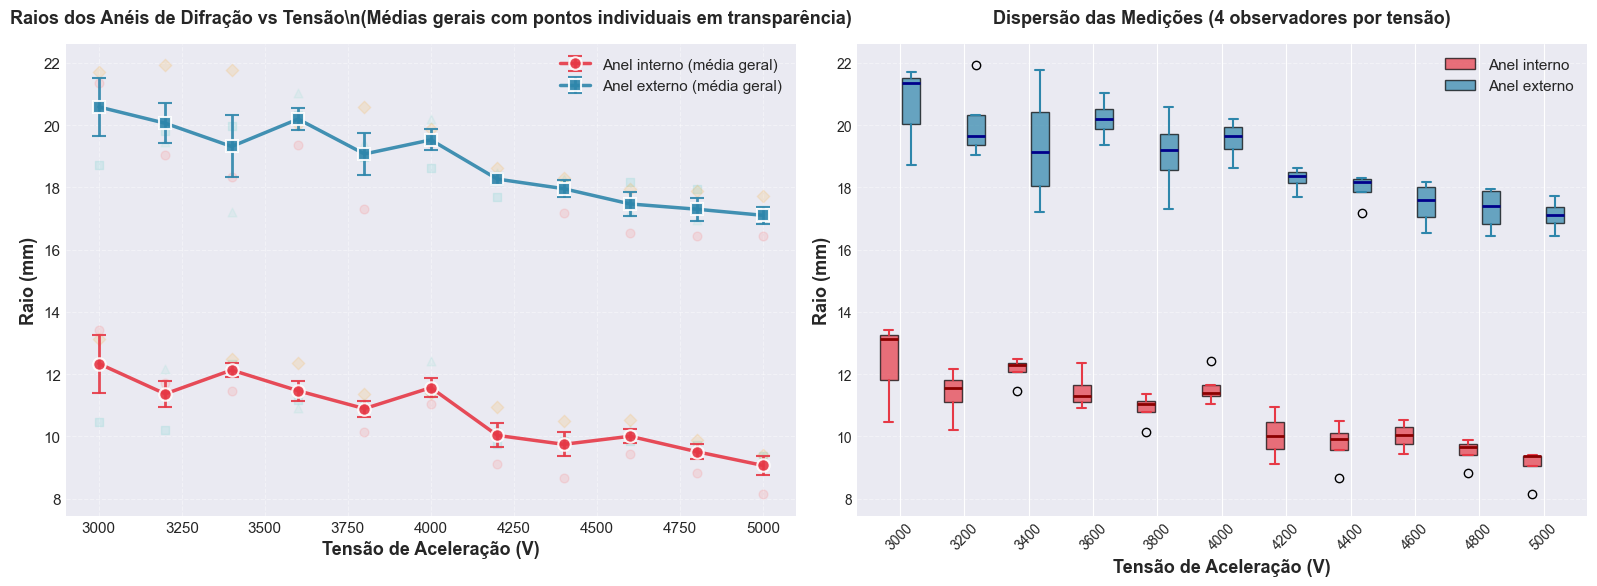

In [87]:
# Criando visualização simples dos raios vs tensão
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ========== GRÁFICO 1: Raios dos anéis em função da tensão ==========
# Plotando médias gerais com destaque
ax1.errorbar(df_resultado['Tensao_V'], df_resultado['r1_medio'],
             yerr=df_resultado['s_r1'],
             fmt='o-', capsize=5, capthick=2, markersize=9, linewidth=2.5,
             label='Anel interno (média geral)', color='#E63946', 
             elinewidth=2, alpha=0.9, markeredgecolor='white', markeredgewidth=1.5)

ax1.errorbar(df_resultado['Tensao_V'], df_resultado['r2_medio'],
             yerr=df_resultado['s_r2'],
             fmt='s-', capsize=5, capthick=2, markersize=9, linewidth=2.5,
             label='Anel externo (média geral)', color='#2E86AB',
             elinewidth=2, alpha=0.9, markeredgecolor='white', markeredgewidth=1.5)

# Adicionando pontos individuais com transparência (sem poluir)
for pessoa, marker, color in [('f', 'o', '#FF6B6B'), ('m', 's', '#4ECDC4'), 
                               ('p', '^', '#95E1D3'), ('g', 'D', '#F9A825')]:
    dados_pessoa = df_individual[df_individual['pessoa'] == pessoa]
    ax1.scatter(dados_pessoa['Tensao_V'], dados_pessoa['r1'], 
               marker=marker, s=40, alpha=0.15, color=color)
    ax1.scatter(dados_pessoa['Tensao_V'], dados_pessoa['r2'], 
               marker=marker, s=40, alpha=0.15, color=color)

ax1.set_xlabel('Tensão de Aceleração (V)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Raio (mm)', fontsize=13, fontweight='bold')
ax1.set_title('Raios dos Anéis de Difração vs Tensão\\n(Médias gerais com pontos individuais em transparência)',
              fontsize=13, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.4, linestyle='--')
ax1.legend(fontsize=11, framealpha=0.95)
ax1.tick_params(labelsize=11)

# ========== GRÁFICO 2: Box plots para visualizar dispersão ==========
posicoes = np.arange(len(df_resultado))
largura = 0.35

# Preparando dados para box plots
dados_r1_por_tensao = []
dados_r2_por_tensao = []
for tensao in sorted(df['Tensao_V'].unique()):
    dados_tensao = df[df['Tensao_V'] == tensao]
    dados_r1_por_tensao.append(dados_tensao['r1'].values)
    dados_r2_por_tensao.append(dados_tensao['r2'].values)

bp1 = ax2.boxplot(dados_r1_por_tensao, positions=posicoes - largura/2, widths=largura*0.8,
                   patch_artist=True, showfliers=True,
                   boxprops=dict(facecolor='#E63946', alpha=0.7),
                   medianprops=dict(color='darkred', linewidth=2),
                   whiskerprops=dict(color='#E63946', linewidth=1.5),
                   capprops=dict(color='#E63946', linewidth=1.5))

bp2 = ax2.boxplot(dados_r2_por_tensao, positions=posicoes + largura/2, widths=largura*0.8,
                   patch_artist=True, showfliers=True,
                   boxprops=dict(facecolor='#2E86AB', alpha=0.7),
                   medianprops=dict(color='darkblue', linewidth=2),
                   whiskerprops=dict(color='#2E86AB', linewidth=1.5),
                   capprops=dict(color='#2E86AB', linewidth=1.5))

ax2.set_xticks(posicoes)
ax2.set_xticklabels([f'{int(v)}' for v in sorted(df['Tensao_V'].unique())], rotation=45)
ax2.set_xlabel('Tensão de Aceleração (V)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Raio (mm)', fontsize=13, fontweight='bold')
ax2.set_title('Dispersão das Medições (4 observadores por tensão)',
              fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.4, linestyle='--', axis='y')
ax2.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Anel interno', 'Anel externo'],
          fontsize=11, framealpha=0.95)
ax2.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('raios_vs_tensao.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Gráfico salvo em 'raios_vs_tensao.png'")
plt.show()

In [88]:
print("="*70)
print("SEÇÃO 5.2 - DETERMINAÇÃO DOS COMPRIMENTOS DE ONDA EXPERIMENTAIS")
print("="*70)

# Para cada medição individual, calculamos λ1, λ2 e λ_medio
# λ = r·d/L (em nm, pois r está em mm, d em nm, e L em mm)
df['lambda1'] = (df['r1'] * d10) / L  # nm
df['lambda2'] = (df['r2'] * d11) / L  # nm
df['lambda_medio_individual'] = (df['lambda1'] + df['lambda2']) / 2

# Agora calculamos as médias e incertezas para cada tensão
resultados_lambda = []
for tensao in sorted(df['Tensao_V'].unique()):
    dados_tensao = df[df['Tensao_V'] == tensao]
    n = len(dados_tensao)

    # Médias dos 4 valores de λ_medio
    lambda_medio = dados_tensao['lambda_medio_individual'].mean()

    # Desvio padrão da média (incerteza estatística)
    s_lambda_medio = dados_tensao['lambda_medio_individual'].std(ddof=1) / np.sqrt(n) if n > 1 else 0

    resultados_lambda.append({
        'Tensao_V': tensao,
        'lambda_medio': lambda_medio,
        's_lambda_medio': s_lambda_medio,
        'n_medidas': n
    })

df_lambda = pd.DataFrame(resultados_lambda)

# Substituindo os valores no df_resultado
df_resultado = df_resultado.merge(df_lambda[['Tensao_V', 'lambda_medio', 's_lambda_medio']],
                                   on='Tensao_V', how='left', suffixes=('_old', ''))
df_resultado = df_resultado.drop(columns=['lambda_medio_old', 's_lambda_medio_old'], errors='ignore')

print("\nComprimentos de onda médios com incertezas estatísticas (em nm):\n")
display_df = df_resultado[['Tensao_V', 'lambda_medio', 's_lambda_medio', 'n_medidas']].copy()
display_df['λ ± σ'] = display_df.apply(
    lambda row: f"{row['lambda_medio']:.4f} ± {row['s_lambda_medio']:.4f}", axis=1
)
print(display_df[['Tensao_V', 'λ ± σ', 'n_medidas']].to_string(index=False))
print("\n✓ Comprimentos de onda experimentais determinados!")

SEÇÃO 5.2 - DETERMINAÇÃO DOS COMPRIMENTOS DE ONDA EXPERIMENTAIS

Comprimentos de onda médios com incertezas estatísticas (em nm):

 Tensao_V           λ ± σ  n_medidas
   3000.0 0.0206 ± 0.0013          3
   3200.0 0.0196 ± 0.0004          4
   3400.0 0.0198 ± 0.0006          4
   3600.0 0.0197 ± 0.0002          4
   3800.0 0.0187 ± 0.0006          4
   4000.0 0.0195 ± 0.0004          4
   4200.0 0.0175 ± 0.0004          4
   4400.0 0.0171 ± 0.0005          4
   4600.0 0.0171 ± 0.0003          4
   4800.0 0.0166 ± 0.0004          4
   5000.0 0.0161 ± 0.0004          4

✓ Comprimentos de onda experimentais determinados!


In [89]:
print("="*70)
print("SEÇÃO 5.4 - COMPARAÇÃO COM A TEORIA DE DE BROGLIE")
print("="*70)

# λ_teórico = h / sqrt(2·m_e·e·U_a)
# Em unidades práticas: λ[pm] = 1226.4 / sqrt(U_a[V])
df_resultado['lambda_teorico_pm'] = 1226.4 / np.sqrt(df_resultado['Tensao_V'])
df_resultado['lambda_medio_pm'] = df_resultado['lambda_medio'] * 1000  # nm para pm
df_resultado['s_lambda_medio_pm'] = df_resultado['s_lambda_medio'] * 1000  # nm para pm

# Diferença relativa percentual
df_resultado['diff_relativa_%'] = np.abs(
    (df_resultado['lambda_medio_pm'] - df_resultado['lambda_teorico_pm']) / 
    df_resultado['lambda_teorico_pm']
) * 100

print("\nComparação Experimental vs Teórico (em pm):\n")
display_df = df_resultado[['Tensao_V', 'lambda_medio_pm', 's_lambda_medio_pm', 
                           'lambda_teorico_pm', 'diff_relativa_%']].copy()
display_df.columns = ['Tensão (V)', 'λ_exp (pm)', 'σ_exp (pm)', 'λ_teórico (pm)', 'Diff. Rel. (%)']
print(display_df.to_string(index=False, float_format='%.3f'))

print(f"\nDiferença relativa média: {df_resultado['diff_relativa_%'].mean():.2f}%")
print("✓ Comparação com teoria concluída!")

SEÇÃO 5.4 - COMPARAÇÃO COM A TEORIA DE DE BROGLIE

Comparação Experimental vs Teórico (em pm):

 Tensão (V)  λ_exp (pm)  σ_exp (pm)  λ_teórico (pm)  Diff. Rel. (%)
   3000.000      20.641       1.255          22.391           7.817
   3200.000      19.554       0.442          21.680           9.805
   3400.000      19.839       0.614          21.033           5.674
   3600.000      19.706       0.239          20.440           3.593
   3800.000      18.664       0.555          19.895           6.188
   4000.000      19.462       0.379          19.391           0.364
   4200.000      17.535       0.392          18.924           7.340
   4400.000      17.138       0.457          18.489           7.307
   4600.000      17.117       0.340          18.082           5.337
   4800.000      16.614       0.371          17.702           6.146
   5000.000      16.139       0.380          17.344           6.949

Diferença relativa média: 6.05%
✓ Comparação com teoria concluída!


## 7. Seção 5.5 - Análise Gráfica e Determinação da Constante de Planck

Seguindo o método descrito no roteiro (seções 2.4 e 5.5), construímos o gráfico:

$$\lambda = A \cdot \frac{1}{\sqrt{U_a}} + B$$

onde:
- $A = \frac{h}{\sqrt{2m_e e}}$ (coeficiente angular)
- $B \approx 0$ (coeficiente linear, idealmente zero)

Através do ajuste linear (mínimos quadrados), determinamos $A$ e, consequentemente:

$$h_{exp} = A \sqrt{2m_e e}$$

In [90]:
print("="*70)
print("SEÇÃO 5.5 - ANÁLISE GRÁFICA E DETERMINAÇÃO DE h")
print("="*70)

# Preparando variáveis para regressão linear
# x = 1/sqrt(U_a) [em V^(-1/2)]
# y = lambda_medio [em metros]
x = 1 / np.sqrt(df_resultado['Tensao_V'])
y = df_resultado['lambda_medio'] * 1e-9  # Convertendo nm para m

# Regressão linear pelo método dos mínimos quadrados
A, B, r_value, p_value, std_err = stats.linregress(x, y)
R_squared = r_value**2

print(f"\nResultados da regressão linear (λ = A/√U_a + B):")
print(f"  Coeficiente angular (A):     {A:.6e} m·V^(1/2)")
print(f"  Coeficiente linear (B):      {B:.6e} m")
print(f"  Coeficiente de correlação:   R² = {R_squared:.6f}")
print(f"  Erro padrão de A:            {std_err:.6e} m·V^(1/2)")

# Determinação experimental da constante de Planck
# h = A * sqrt(2·m_e·e)
h_exp = A * np.sqrt(2 * m_e * e)

# Propagação de erro para h
s_h = std_err * np.sqrt(2 * m_e * e)

print(f"\n→ Constante de Planck experimental:")
print(f"  h_exp = ({h_exp:.4e} ± {s_h:.4e}) J·s")
print(f"  h_teo = {h_teorico:.4e} J·s")
print(f"  Discrepância: {np.abs((h_exp - h_teorico)/h_teorico)*100:.2f}%")

# Avaliação de compatibilidade estatística
diferenca_absoluta = np.abs(h_exp - h_teorico)
limite_2sigma = 2 * s_h
compatibilidade = diferenca_absoluta <= limite_2sigma

print("="*70)

SEÇÃO 5.5 - ANÁLISE GRÁFICA E DETERMINAÇÃO DE h

Resultados da regressão linear (λ = A/√U_a + B):
  Coeficiente angular (A):     1.067292e-09 m·V^(1/2)
  Coeficiente linear (B):      1.361701e-12 m
  Coeficiente de correlação:   R² = 0.887917
  Erro padrão de A:            1.263998e-10 m·V^(1/2)

→ Constante de Planck experimental:
  h_exp = (5.7659e-34 ± 6.8285e-35) J·s
  h_teo = 6.6260e-34 J·s
  Discrepância: 12.98%


## 8. Seção 5.6 - Avaliação Final do Resultado

Avaliamos o resultado experimental comparando com o valor teórico aceito da constante de Planck.

In [91]:
print("="*70)
print("RESUMO FINAL DOS RESULTADOS")
print("="*70)

# Discrepância relativa percentual
discrepancia = np.abs((h_exp - h_teorico) / h_teorico) * 100

print(f"\nConstante de Planck:")
print(f"  h_experimental = ({h_exp:.4e} ± {s_h:.4e}) J·s")
print(f"  h_teórico      = {h_teorico:.4e} J·s")
print(f"  Discrepância   = {discrepancia:.2f}%")
print(f"\nQualidade do ajuste:")
print(f"  R² = {R_squared:.6f}")

print("="*70)
print("\n✓ Análise completa!")

RESUMO FINAL DOS RESULTADOS

Constante de Planck:
  h_experimental = (5.7659e-34 ± 6.8285e-35) J·s
  h_teórico      = 6.6260e-34 J·s
  Discrepância   = 12.98%

Qualidade do ajuste:
  R² = 0.887917

✓ Análise completa!


## 7.1 Visualização dos Resultados

Criamos dois gráficos principais para visualizar os resultados:

1. **λ vs 1/√U_a**: Ajuste linear para determinação experimental da constante de Planck
2. **λ vs U_a**: Comparação entre valores experimentais e previsão teórica de De Broglie

✓ Gráficos salvos em 'analise_difracao_eletrons.png'


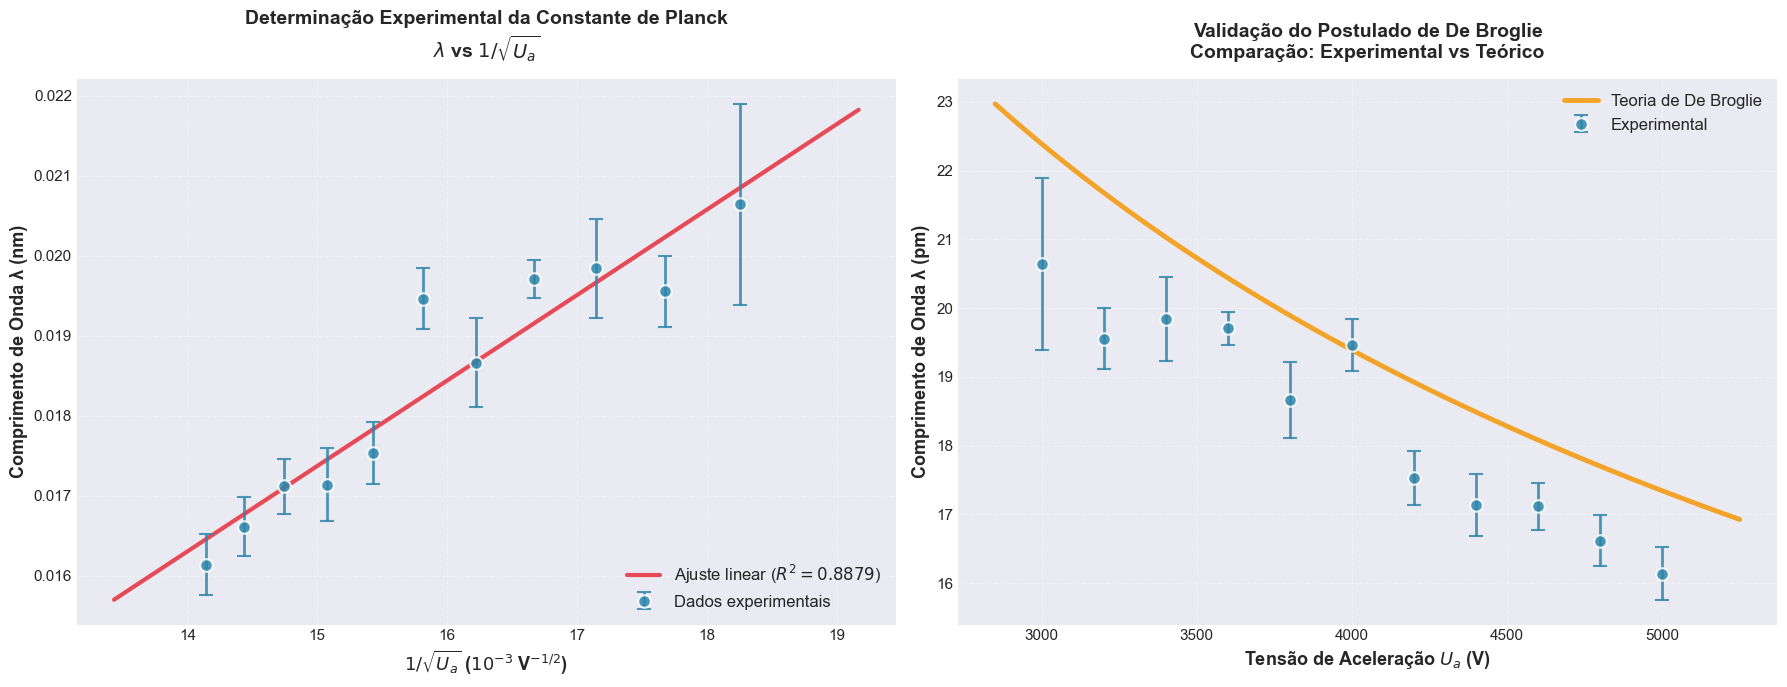

In [92]:
# Criando figura com 2 subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# ========== GRÁFICO 1: λ vs 1/√U_a (Determinação de h) ==========
x_plot = np.linspace(min(x)*0.95, max(x)*1.05, 200)
y_plot = A * x_plot + B

# Plotando dados experimentais
ax1.errorbar(x * 1000, df_resultado['lambda_medio'],
             yerr=df_resultado['s_lambda_medio'],
             fmt='o', capsize=5, capthick=2, markersize=9,
             label='Dados experimentais', color='#2E86AB', 
             elinewidth=2, alpha=0.85, markeredgecolor='white',
             markeredgewidth=1.5, zorder=5)

# Linha de ajuste
ax1.plot(x_plot * 1000, y_plot * 1e9, '-', linewidth=3,
         label=f'Ajuste linear ($R^2 = {R_squared:.4f}$)', 
         color='#E63946', alpha=0.9, zorder=3)

ax1.set_xlabel('$1/\\sqrt{U_a}$ ($10^{-3}$ V$^{-1/2}$)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Comprimento de Onda λ (nm)', fontsize=13, fontweight='bold')
ax1.set_title('Determinação Experimental da Constante de Planck\n$\\lambda$ vs $1/\\sqrt{U_a}$',
              fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.35, linestyle='--', linewidth=0.8)
ax1.legend(fontsize=12, loc='lower right', framealpha=0.9)
ax1.tick_params(labelsize=11)

# ========== GRÁFICO 2: λ vs U_a (Comparação) ==========
tensao_plot = np.linspace(df_resultado['Tensao_V'].min()*0.95,
                          df_resultado['Tensao_V'].max()*1.05, 300)
lambda_teorico_plot = 1226.4 / np.sqrt(tensao_plot)

# Teoria
ax2.plot(tensao_plot, lambda_teorico_plot, '-', linewidth=3.5,
         label='Teoria de De Broglie', color='#F39C12', alpha=0.9, zorder=3)

# Dados experimentais
ax2.errorbar(df_resultado['Tensao_V'], df_resultado['lambda_medio_pm'],
             yerr=df_resultado['s_lambda_medio_pm'],
             fmt='o', capsize=5, capthick=2, markersize=9,
             label='Experimental', color='#2E86AB',
             elinewidth=2, alpha=0.85, markeredgecolor='white',
             markeredgewidth=1.5, zorder=5)

ax2.set_xlabel('Tensão de Aceleração $U_a$ (V)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Comprimento de Onda λ (pm)', fontsize=13, fontweight='bold')
ax2.set_title('Validação do Postulado de De Broglie\nComparação: Experimental vs Teórico',
              fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.35, linestyle='--', linewidth=0.8)
ax2.legend(fontsize=12, loc='upper right', framealpha=0.9)
ax2.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('analise_difracao_eletrons.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Gráficos salvos em 'analise_difracao_eletrons.png'")
plt.show()